# 降维

降维主要有两种手段：**投影、流形学习**

对于处于$n$维空间的训练数据，并不是完全无规律的均匀分布，如果将其用$n$个特征表示，有些特征可能是独立，但是有些特征间可能存在着关联关系。这就导致这些数据可能都只存在于一个更小的子空间内，如果找到这种更小的子空间，并将其投影到子空间中，就实现了数据降维。

但是很有情况下这类子空间可能存在翻转和弯曲，数据形状类似于水流，所以又叫流形（manifold）。对于流形数据进行建模实现降维的算法称之为流形学习，依赖于流形假设：**大多数真实世界的高维数据类似于低维的流形数据**。

# 1. PCA

PCA是使用得最普遍的降维算法，要将数据降维到$k$维子空间，包括两个步骤：
- 找出最能保存数据方差的超平面（包括k个基向量）
- 将数据投影到该超平面

这$k$个基向量又称为主成分。经过数学计算可知，这些基向量分别是数据矩阵最大的$k$的特征值所对应的单位特征向量。

注：PCA假设数据最初是以原点为中心

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt

构造一群三维数据

In [44]:
m = 100
X = np.empty((m, 3))
noise = 0.1
angles = np.random.rand(m) * np.pi * 2 - 0.5

X[:, 0] = 3 + np.cos(angles) / 2 + noise * np.random.randn(m)/2
X[:, 1] = 5 + np.sin(angles) + noise * np.random.randn(m)/2
X[:, 2] = X[:, 0] * 0.1 + X[:, 1] * 0.4 + noise * np.random.randn(m)

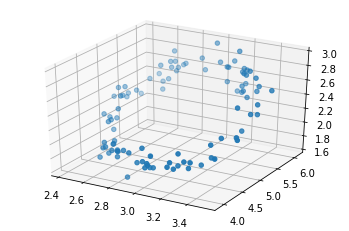

In [45]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])

## 1.1 使用svd进行PCA

In [46]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

In [47]:
indices = s.argsort()[::-1][:2]
W2 = Vt[:, indices]

In [48]:
X_PCAed = X_centered.dot(W2)
X_PCAed.shape

(100, 2)

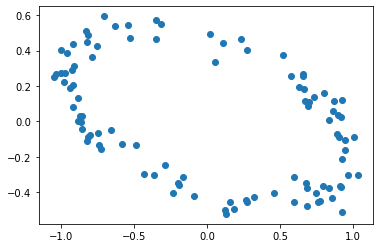

In [49]:
plt.scatter(X_PCAed[:, 0], X_PCAed[:, 1])

## 1.2 使用Scikit-Learn

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

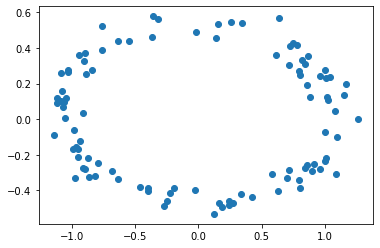

In [63]:
plt.scatter(X2D[:, 0], X2D[:, 1])

In [60]:
pca.components_, W2.T

(array([[ 0.01649126,  0.92540299,  0.3786256 ],
        [ 0.99574441, -0.04953968,  0.07771026]]),
 array([[ 0.01649126,  0.99574441, -0.0906703 ],
        [ 0.92540299, -0.04953968, -0.37573279]]))

降维之后可解释的方差比例，1减去其合为损失的方差信息

In [64]:
pca.explained_variance_ratio_

array([0.84853338, 0.14161492])

In [70]:
loss_percent = 1 - pca.explained_variance_ratio_.sum()
print('损失方差：{:.4f}%'.format(loss_percent*100))

损失方差：0.9852%


## 1.3 选择PCA降维后的维度

有两个办法：
1. 在原始维度进行PCA，然后累加其可解释的方差比例(explained_variance_ratio_)；当达到设定的阈值时，对应的维度就是理想的降维维度
2. 前半部分同上，然后将其图绘制出来，进行观察进行取值
3. 在pca将参数n_components设为一个介于0和1之间的小数，指定需要保留方差的比例

In [72]:
from sklearn.datasets import load_digits
mnist = load_digits()

In [76]:
from sklearn.model_selection import train_test_split
X = mnist['data']
y = mnist['target']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [90]:
print('数据初始维度为：', X_train.shape[-1])

数据初始维度为： 64


In [91]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

28

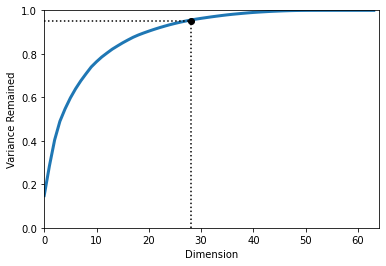

In [97]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 64, 0, 1])
plt.xlabel('Dimension')
plt.ylabel('Variance Remained')
plt.plot([d, d], [0, 0.95], 'k:')
plt.plot([0, d], [0.95, 0.95], 'k:')
plt.plot(d, 0.95, 'ko')

In [109]:
pca = PCA(n_components=0.95)
X_PCAed = pca.fit_transform(X_train)
X_Recovered = pca.inverse_transform(X_PCAed)
print('自动选择降维的维度：',pca.n_components_)
print('保留的方差：',pca.explained_variance_ratio_.sum())

自动选择降维的维度： 28
保留的方差： 0.9506055656982879


In [115]:
def plot_digits(ax, instances, images_per_row=5, **options):
    size = 8
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    ax.imshow(image, cmap = 'binary', **options)
    ax.axis("off")

## 1.4 数据压缩与还原

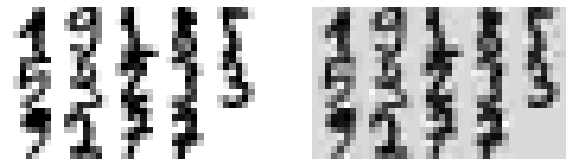

In [120]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
plot_digits(ax[0], X_train[::100])
plot_digits(ax[1], X_Recovered[::100])

# 2. 随机化PCA(Randomized PCA)

当数据量较大时，计算SVD的时间较长，随机化PCA是通过随机算法找到数据的近似前$k$个主成分，复杂度为$O(m\times d^2)+O(d^3)$，普通的SVD复杂度是$O(m\times n^2) + O(n^3)$。

用法是将PCA()的超参数`svd_solver`设置为`"randomized"`，实际上，该参数默认值为`"auto"`，当$m$或者$n$大于500或者$d$小于$m$或$n$的$80%$时，自动选择使用随机化PCA。要始终使用完全的SVD计算，可将此参数设置为`"full"`。

# 3. 增量化PCA(Incremental PCA)

为解决**数据量过大**的问题，及数据是在线**流式接收**的场景，有了增量化PCA算法。

注：降维的维数要大于每个batch数据的个数

In [132]:
from sklearn.decomposition import IncrementalPCA
n_batchs = 10
inc_pca = IncrementalPCA(n_components=28)
for X_batch in np.array_split(X_train, n_batchs):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)
X_recovered = inc_pca.inverse_transform(X_reduced)

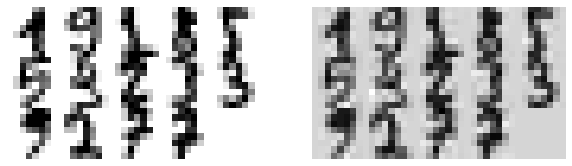

In [133]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
plot_digits(ax[0], X_train[::100])
plot_digits(ax[1], X_recovered[::100])

# 4. Kernel PCA

给PCA引入核方法，使得PCA可以进行非线性投影操作

原先的投影操作为两个向量进行内积，为线性核（linear kernel），即$k(x,y)=x^Ty$，核方法是将线性核替换为其它的核，实现非线性映射。

In [173]:
X, t = sklearn.datasets.make_swiss_roll(n_samples=3000, noise=0.2)

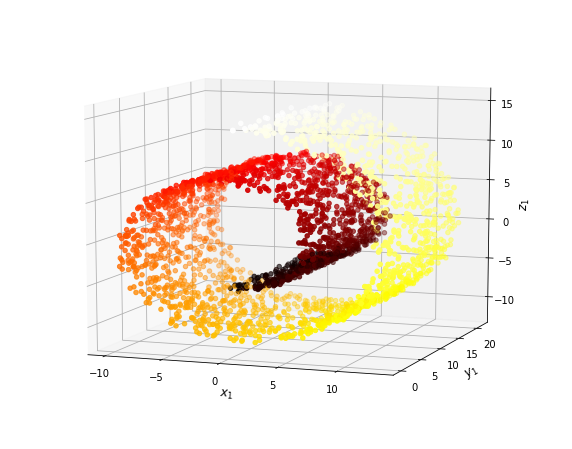

In [143]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=t, cmap='hot')
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$y_1$', fontsize=12)
ax.set_zlabel('$z_1$', fontsize=12)
ax.view_init(10, -70)

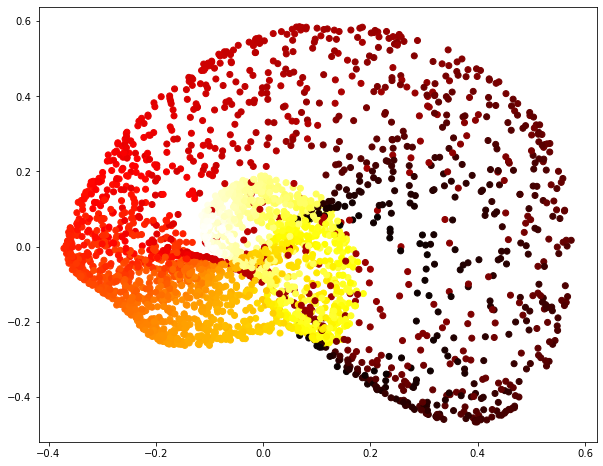

In [145]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=t, cmap='hot')

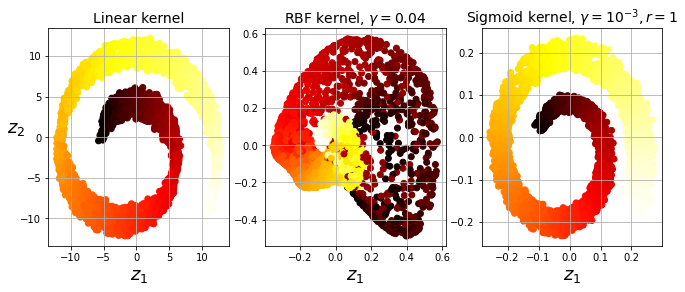

In [151]:
lin_pca = KernelPCA(2, kernel='linear', fit_inverse_transform=True)
rbf_pca = KernelPCA(2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(2, kernel='sigmoid', gamma=0.001, coef0=1, fit_inverse_transform=True)

plt.figure(figsize=(11, 4))
plt_set = ((131, lin_pca, 'Linear kernel'),
          (132, rbf_pca, 'RBF kernel, $\gamma=0.04$'),
          (133, sig_pca, 'Sigmoid kernel, $\gamma=10^{-3}, r=1$'))

for subplot, pca, title in plt_set:
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='hot')
    plt.xlabel('$z_1$', fontsize=18)
    if subplot == 131:
        plt.ylabel('$z_2$', fontsize=18, rotation=0)
    plt.grid(True)

Text(0.5, 0, 'Reduced data')

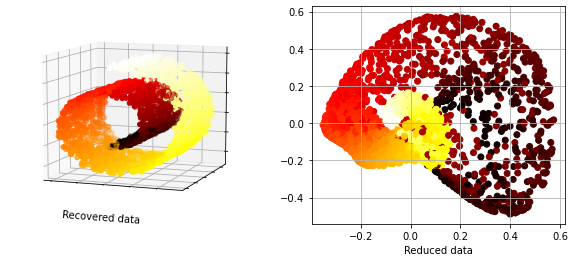

In [160]:
plt.figure(figsize=(10, 4))
X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(121, projection='3d')
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap='hot')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, -70)
ax.set_xlabel('Recovered data')
ax = plt.subplot(122)
X_reduced = rbf_pca.fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:,1], c=t, cmap='hot')
ax.grid(True)
ax.set_xlabel('Reduced data')

## 4.1 对核PCA进行调参

In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [178]:
y = t > 8

In [190]:
clf = Pipeline([
    ('kpca', KernelPCA(2)),
    ('log_reg', LogisticRegression())
], verbose=False)
param_grid = [{
    'kpca__gamma': np.linspace(0.04, 0.08, 40),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.04      , 0.04102564, 0.04205128, 0.04307692, 0.04410256,
       0.04512821, 0.04615385, 0.04717949, 0.04820513, 0.04923077,
       0.05025641, 0.05128205, 0.05230769, 0.05333333, 0.05435897,
       0.05538462, 0.05641026, 0.0574359 , 0.05846154, 0.05948718,
       0.06051282, 0.06153846, 0.0625641 , 0.06358974, 0.06461538,
       0.06564103, 0.06666667, 0.06769231, 0.06871795, 0.06974359,
       0.07076923, 0.07179487, 0.07282051, 0.07384615, 0.07487179,
       0.07589744, 0.07692308, 0.07794872, 0.07897436, 0.08      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [191]:
grid_search.best_estimator_

Pipeline(steps=[('kpca',
                 KernelPCA(gamma=0.07589743589743589, kernel='rbf',
                           n_components=2)),
                ('log_reg', LogisticRegression())])

In [192]:
grid_search.best_params_, grid_search.best_score_

({'kpca__gamma': 0.07589743589743589, 'kpca__kernel': 'rbf'},
 0.8476666666666667)

In [194]:
rbf_pca = KernelPCA(
    n_components=2, kernel=grid_search.best_params_['kpca__kernel'], 
    gamma=grid_search.best_params_['kpca__gamma'], fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_pre = rbf_pca.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_pre)

3.9232333163228603e-26

# 5. LLE

LLE: Locally Linear Embedding，另外一个非线性降维的技术，不同于核PCA，LLE是一种流形学习，不依赖于投影。其流程可以简单的分为两步：
1. **计算每个样本与其最近邻的相关程度**
2. **寻找最能保持其局部关系的低维向量表示**

In [196]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

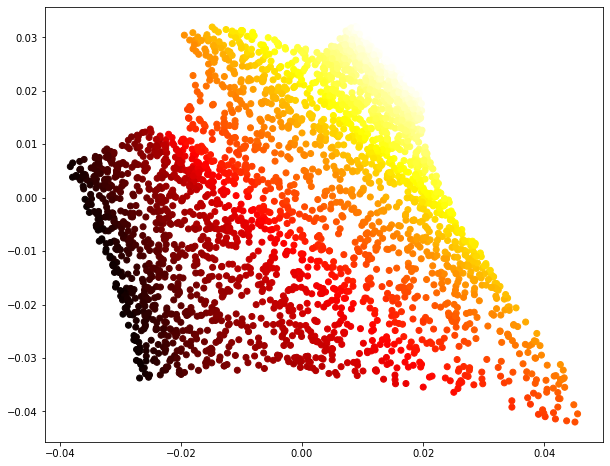

In [199]:
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='hot')

## 5.1 LLE的具体计算操作

第一步：

对每个样本，寻找最近的$k$个邻样本（通过某一种近邻算法），近邻算法参数为neighbors_algorithm，取值有四个：`'auto'|'brute'|'kd_tree'|'ball_tree'`，分别为根据数据自动选择最佳算法、暴力搜索、kd树、球树，默认为自动选择。然后计算出一组权重，使得$x_i$和$\sum_{j\in N_i} w_{ij}x_j$平方距离最小，不属于k近邻的节点权重都为0，通过这一优化问题得到权重矩阵$W$：
$$
\widehat W = \arg \min_W \sum_{i=1}^m(x^{i} - \sum_{j=1}^mw_{ij}x^{(j)})^2
$$

$\widehat W$保留的各样本点的局部信息，第二步是进行降维，降维的同时尽可能保持局部信息。如果$x^i$降维之后得到$z^i$，那么需要使$z_i$和$\sum_{j\in N_i}w_{ij}z_j$间的平方距离也尽可能小，优化问题如下：
$$
\widehat Z = \arg \min_Z \sum_{i=1}^m (z^i - \sum_{j=1}^m \widehat w_{ij} z^j)^2
$$

寻找$k$近邻的复杂度为$O(m\log(m)n\log(k))$，优化权重的复杂度为$O(mnk^3)$，构建低维向量表示的复杂度为$O(dm^2)$。

# 6. MDS



In [206]:
def plot_reduced(X_reduced):
    plt.figure(figsize=(10, 8))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='hot')

In [202]:
from sklearn.manifold import MDS

mds = MDS(n_components=2)
X_reduced_mds = mds.fit_transform(X)

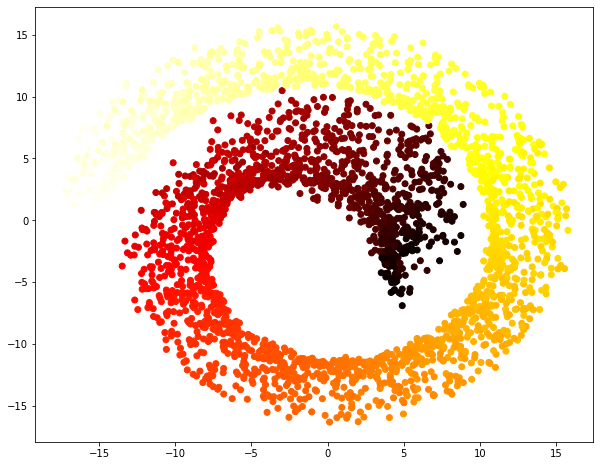

In [207]:
plot_reduced(X_reduced_mds)

In [203]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

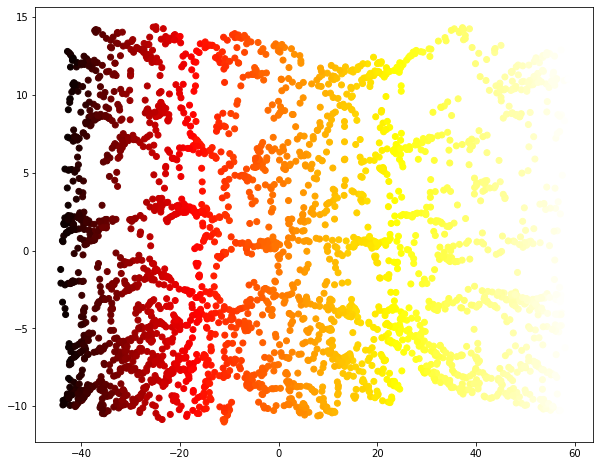

In [208]:
plot_reduced(X_reduced_isomap)

In [204]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_reduced_tsne = tsne.fit_transform(X)

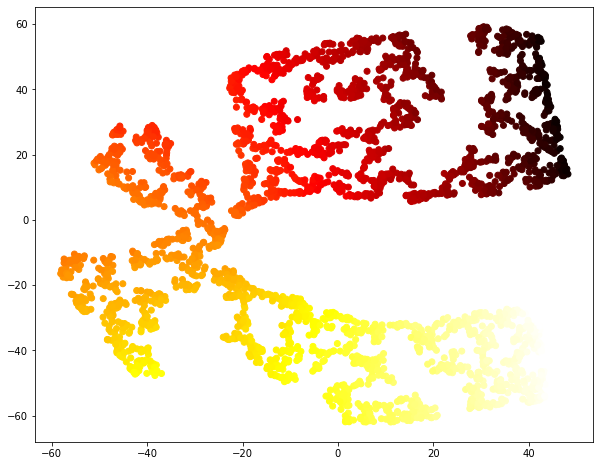

In [209]:
plot_reduced(X_reduced_tsne)

此外还有LDA（隐狄利克雷分析）、随机映射，不过

In [211]:
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection, johnson_lindenstrauss_min_dim

grp = GaussianRandomProjection(n_components=2)
X_reduced_grp = grp.fit_transform(X)